# Mixture of 2 Gaussians
Let's consider an example, where the likelihood is a mixture of two Gaussians with a common mean $\theta$, equal weights and different (fixed) variances:

$$f(x | \theta) = 0.5 * \mathcal{N}(x | \theta, 1) + 0.5 * \mathcal{N}(x | \theta, 0.01)$$

and the prior is uniform: $p(\theta) = \mathcal{U}(-10, 10)$

The posterior is then given as:

In [1]:
import scipy.stats as ss
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import pyabc
from pyabc.plots import plot_marginals
from brrr import skrrrahh

%matplotlib notebook

<IPython.core.display.Javascript object>


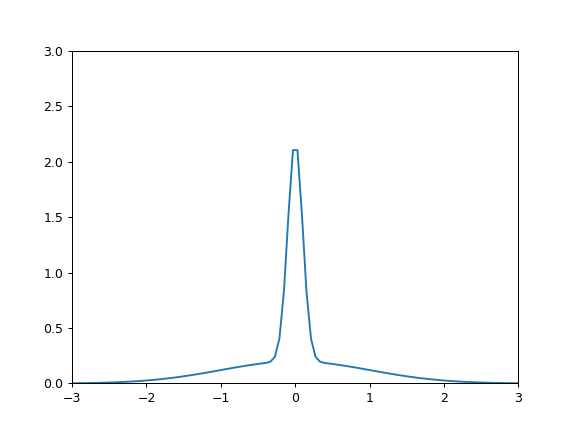

In [2]:
def posterior(mu):
    return 0.5 * ss.norm.pdf(mu, 0, 1) + 0.5 * ss.norm.pdf(mu, 0, 0.1)

x = np.linspace(-3, 3, 100)
plt.figure()
plt.plot(x, posterior(x))
plt.xlim((-3,3))
plt.ylim((0,3))
plt.show()

In the ABC setting, drawing from the posterior, can be realized by sampling from the standard normal distribution and then using the following distance function:

In [3]:
prior = pyabc.Prior('uniform', -10, 20, name='mu')
prior.sample()

def simulator(mu):
    return np.random.normal(mu, 1, size=100)

summary = lambda x: x
    
def rho(y, x):
    if np.random.rand() < 0.5:
        #print(np.abs(x.mean()))
        rho = np.abs(x.mean())
    else:
        #print(np.abs(x[0]))
        rho = np.abs(x[0])
    return rho

y0 = np.array([0.])

## Rejection-ABC

In [4]:
rej = pyabc.RejectionSampler(priors=[prior], simulator=simulator, 
                             summaries=[summary], distance=rho,
                             observation=y0)

rej.sample(nr_samples=1000, threshold=0.025)

Rejection sampler started with threshold: 0.025 and number of samples: 1000
Samples:   1000 - Threshold: 0.0250 - Iterations:     389000 - Acceptance rate: 0.002571 - Time:    10.56 s


<IPython.core.display.Javascript object>


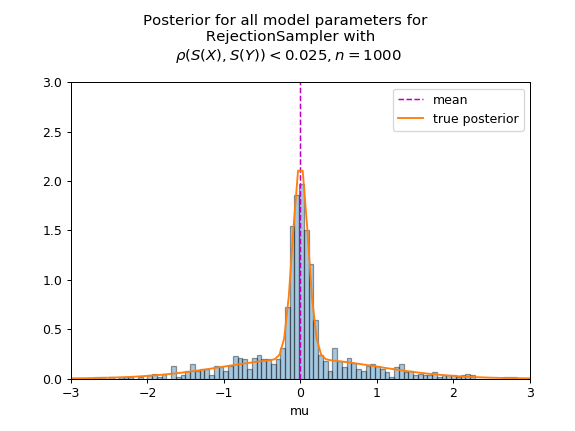

In [5]:
plot_marginals(rej, xlim=[(-3,3)], ylim=(0,3), kde=False)
plt.plot(x, posterior(x), label='true posterior')
plt.legend()

## MCMC-ABC

In [6]:
mcmc = pyabc.MCMCSampler(priors=[prior], simulator=simulator, 
                         summaries=[summary], distance=rho,
                         observation=y0)
mcmc.sample(nr_samples=1_000, threshold=0.025, step_size=[0.15**2])

MCMC sampler started with threshold: 0.025 and number of samples: 1000
Samples:   1000 - Threshold: 0.0250 - Iterations:      21850 - Acceptance rate: 0.045767 - Time:     8.25 s


<IPython.core.display.Javascript object>


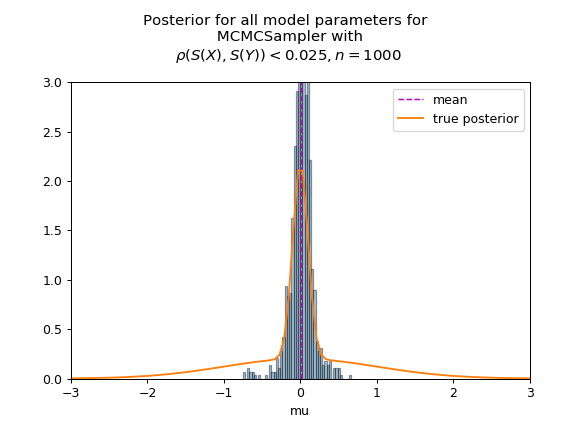

In [7]:
plot_marginals(mcmc, xlim=[(-3,3)], ylim=(0,3), kde=False)
plt.plot(x, posterior(x), label='true posterior')
plt.legend()

# BOLFI

In [4]:
bolfi = pyabc.BOLFI(priors=[prior], simulator=simulator,
                 summaries=[summary], distance=rho,
                  observation=y0, domain=[(-3,3)])
bolfi.sample(nr_samples=10_000, threshold=0.025, initial_evidence_size=100, max_iter=1000, max_time=120, n_chains=4, burn_in=1000)
skrrrahh()

BOLFI sampler started with threshold: 0.025 and number of samples: 10000
Starting Bayesian Optimization


AttributeError: 'BOLFI' object has no attribute 'simulate'

<IPython.core.display.Javascript object>


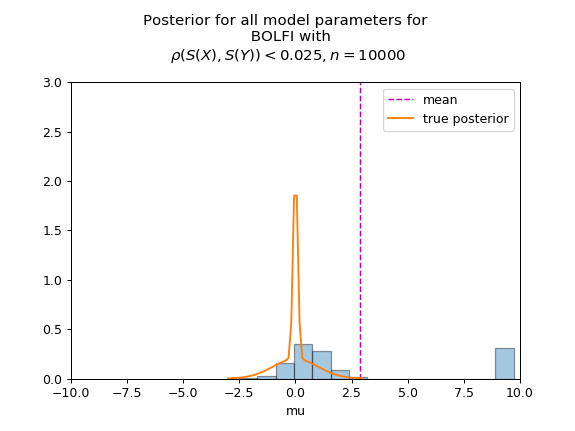

In [7]:
plot_marginals(bolfi, xlim=[(-10,10)], ylim=(0,3), kde=False)
plt.plot(x, posterior(x), label='true posterior')
plt.legend()

In [9]:
bolfi.Thetas

array([[ 9.72932396],
       [ 9.72932396],
       [ 9.72932396],
       ..., 
       [-0.52438399],
       [-0.52438399],
       [-0.52438399]])

<IPython.core.display.Javascript object>


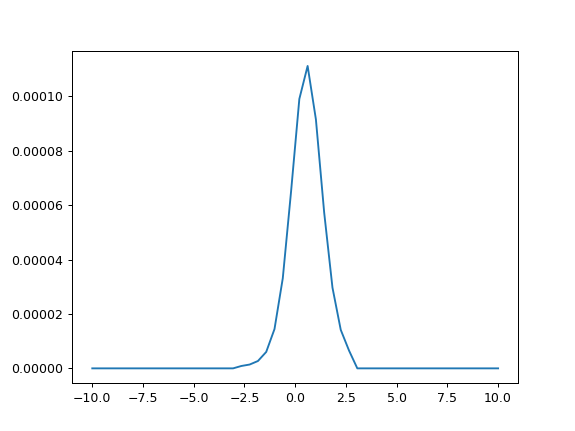

In [8]:
plt.figure()
x = np.linspace(-10,10)
plt.plot(x, [bolfi.posterior(np.atleast_1d(x_i)) for x_i in x], label='BOLFI')
